In [1]:
from jw_utils import file_utils as fu
import plotly.graph_objects as go
import plotly.offline as pyo
import numpy as np
from Bio import Phylo
import pandas as pd
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from jw_utils import jw_draw_tree
import os
import json
from jw_utils import ncbi_utils as nu

### Read in distance matrix generated in 'dwnld_assemblies_make_distMatrix.ipynb'

In [2]:
dist_matrix_lowTriang_df = pd.read_csv('./dist_mat.csv').set_index('Unnamed: 0')
dist_matrix_df = dist_matrix_lowTriang_df.fillna(0) + dist_matrix_lowTriang_df.T.fillna(0)

In [11]:
def get_n50_d(json_summary_fp):
    summary_d = nu.parse_ncbi_summary(json_summary_fp)
    n50 = {}
    for acc, summ_dict in summary_d.items():
        n50_val = summ_dict['assembly_stats']['contig_n50']
        n50[acc] = n50_val
    return n50

json_summary_fp = './summary_all.json'
n50 = get_n50_d(json_summary_fp)

In [12]:
def make_phylo_distMatrix(df):
    "make a Bio.Phylo distance matrix from a lower triangle df with names set as the df.index"

    matrix = []
    names=[]
    for i, name in enumerate(df.index):
        names.append(name)
        matrix.append(list(df.iloc[i, :(i+1)]))
    return Phylo.TreeConstruction.DistanceMatrix(names=names, matrix=matrix)

In [13]:
def deduplicate_genomes(distance_matrix, quality_scores, similarity_threshold):
    """
    Deduplicates genomes based on a similarity threshold and quality scores.

    Parameters:
        distance_matrix (pd.DataFrame): Square DataFrame where index and columns are genome accessions,
                                        and values are distances between genomes.
        quality_scores (dict): Dictionary mapping genome accessions to quality scores.
        similarity_threshold (float): Threshold for similarity. Genomes with a distance below this
                                       are considered similar.

    Returns:
        list: List of genome accessions to keep after deduplication.
    """
    # Make a copy of the distance matrix to avoid modifying the original
    remaining_genomes = set(distance_matrix.index)
    
    # Convert quality_scores to a pandas Series for easy sorting and lookups
    quality_series = pd.Series(quality_scores)
    
    # Sort genomes by quality score (highest to lowest)
    genomes_sorted = quality_series.loc[list(remaining_genomes)].sort_values(ascending=False).index
    
    # Set to track genomes to keep
    to_keep = set()
    
    # Iterate over genomes by quality score
    for genome in genomes_sorted:
        if genome not in remaining_genomes:
            continue  # Skip genomes already removed
        
        # Add the genome to the "to keep" set
        to_keep.add(genome)
        
        # Find all genomes that are similar to the current genome
        similar_genomes = distance_matrix.loc[genome, list(remaining_genomes)]
        similar_genomes = similar_genomes[similar_genomes < similarity_threshold].index
        
        # Remove all similar genomes except the one we're keeping
        remaining_genomes -= set(similar_genomes) - {genome}
    
    return list(to_keep)


to_keep = deduplicate_genomes(dist_matrix_df, n50, similarity_threshold=0.0125)
len(to_keep)

230

In [38]:
import plotly.express as px
# Display all sequential colorscales
fig = px.colors.sequential.swatches()
import plotly.express as px
import plotly.io as pio
scales = px.colors.named_colorscales()
colors = px.colors.sample_colorscale(scales[39],np.linspace(0,1,17))

In [14]:
import shutil
def move_proteomes(proteome_source, proteome_out_dir, proteomes_to_move):
    """Move selected proteomes to own dir"""

    
    os.makedirs(proteome_out_dir, exist_ok=True)
    for proteome in proteomes_to_move:
        source_fp = os.path.join(proteome_source, proteome+'.faa')
        dest_fp = os.path.join(proteome_out_dir, proteome+'.faa')
        if os.path.exists(source_fp):
            shutil.copy(source_fp,dest_fp)
        else:
            print("path does not exist")

#move_proteomes(proteome_source, proteome_out_dir, proteomes_to_move)

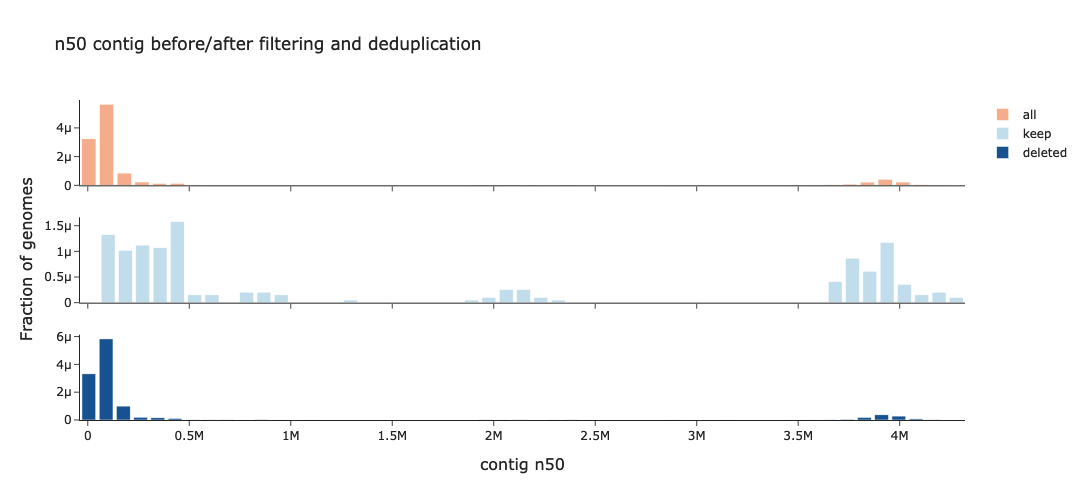

In [58]:
from plotly.subplots import make_subplots
n50_s = pd.Series(n50)
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, y_title="Fraction of genomes", x_title="contig n50")
to_delete = list(set(n50_s.index).difference(to_keep))
y,x = np.histogram(n50_s.loc[to_keep], bins=50, density=True)
y_all,x_all = np.histogram(n50_s, bins=50, density=True)
y_del,x_del = np.histogram(n50_s.loc[to_delete], bins=50, density=True)

trace_all = go.Bar(x=x_all, y=y_all, name='all', marker_color=colors[5],)
trace_deduped = go.Bar(x=x, y=y,marker_color=colors[10], name='keep')
trace_deleted = go.Bar(x=x_del, y=y_del,marker_color=colors[15], name='deleted')
fig.add_trace(trace_all, row=1, col=1)
fig.add_trace(trace_deduped, row=2, col=1)
fig.add_trace(trace_deleted, row=3, col=1)
fig.update_layout(title="n50 contig before/after filtering and deduplication",  template="simple_white", height=500)


import plotly.io as pio
pio.write_image(fig, './figures/n50_scores.png')
fig

In [51]:
def make_histogram(one_dim_list, range2 = [0.0125,0.028], bins=100):
    """Return plotly fig from one dimensional list of distances"""
    binsize = (max(range2)-min(range2))/bins

    range1 = [min(one_dim_list),min(range2)]
    range1_num_bins = int((max(range1)-min(range1))/binsize)
    range3 = [max(range2),max(one_dim_list)]
    range3_num_bins = 1

    hist_highly_similar = np.histogram(one_dim_list, range=[0,0.0125], bins=range1_num_bins )
    hist = np.histogram(one_dim_list, range=[0.0125,0.028], bins=bins)
    hist_outliers = np.histogram(one_dim_list, range=[0.028,max(one_dim_list)], bins=range3_num_bins )

    trace_highly_similar = go.Bar(x=hist_highly_similar[1], y=hist_highly_similar[0],marker_color=colors[5], name='highly_similar')
    trace = go.Bar(x=hist[1], y=hist[0],marker_color=colors[10], name='keep')
    trace_outlier = go.Bar(x=hist_outliers[1], y=hist_outliers[0], marker_color=colors[15], name='outliers, > 0.028')

    fig = go.Figure(data=[trace_highly_similar, trace, trace_outlier])
    fig.update_xaxes({'tickfont':
                        {'size':10},
                    'title':{
                        'text': 'minHash distance',
                        'font': {'size':15}
                        }
                    })
    fig.update_yaxes({'title':
                    {'text':'counts, distances',
                        'font':
                            {'size':15}
                        },
                    'tickfont':
                        {'size':10}
                    })
    fig.update_layout({
                    'legend':
                        {'font':
                            {'size':15}}
                    }, template="simple_white",)
    return fig

#### get distribution of minHash genome distances

###### collapse distance matrix to one dimensional list

##### Make plotly histogram of distribution of genome pairwise distances

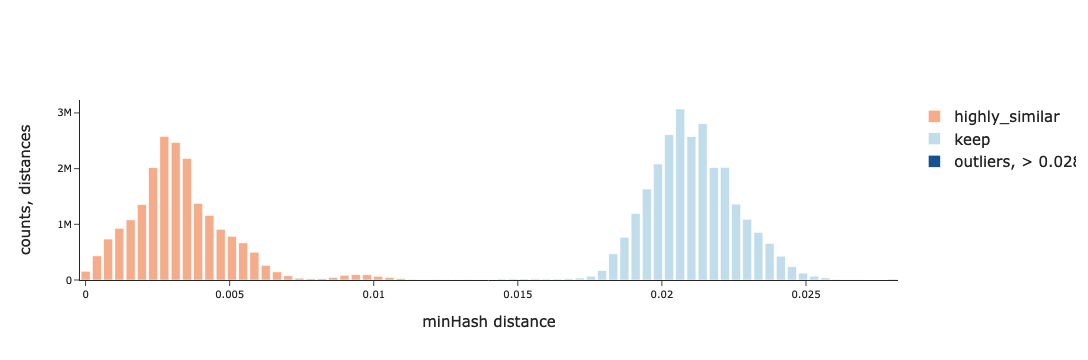

In [56]:
#one_dim_list_all =  dist_matrix_df.melt()['value']
fig_all = make_histogram(one_dim_list_all, range2 = [0.0125,0.028], bins=40) 
pio.write_image(fig_all, './figures/distances_all.png')
fig_all

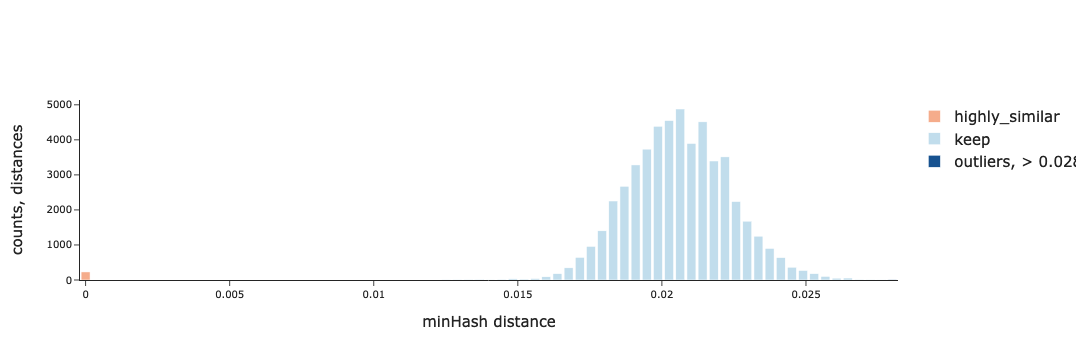

In [55]:
one_dim_list_deduped =  dist_matrix_df.loc[to_keep, to_keep].melt()['value']
fig_deduped = make_histogram(one_dim_list_deduped, range2 = [0.0125,0.028], bins=40) 
pio.write_image(fig_deduped, './figures/distances_deduped.png')
fig_deduped

### Make neighbor joining tree from deduped distance matrix

In [20]:
def reoder_to_keep_accs(to_keep, dist_matrix_lowTriang_df):

    df = dist_matrix_lowTriang_df
    re_ordered_to_keep = []
    for acc in dist_matrix_lowTriang_df.index:
        if acc in to_keep:
            re_ordered_to_keep.append(acc)
    return re_ordered_to_keep

re_ordered_to_keep = reoder_to_keep_accs(to_keep, dist_matrix_lowTriang_df)

dist_matrix_deduped_df = dist_matrix_lowTriang_df.loc[re_ordered_to_keep, re_ordered_to_keep]
phylo_distMatrix = make_phylo_distMatrix(dist_matrix_deduped_df)
if not os.path.exists('./nj_trees'):
    os.makedirs('./nj_trees')
constructor = DistanceTreeConstructor()
njTree = constructor.nj(phylo_distMatrix)
Phylo.write(njTree, format='newick', file='./nj_trees/njTree.nwk')

1

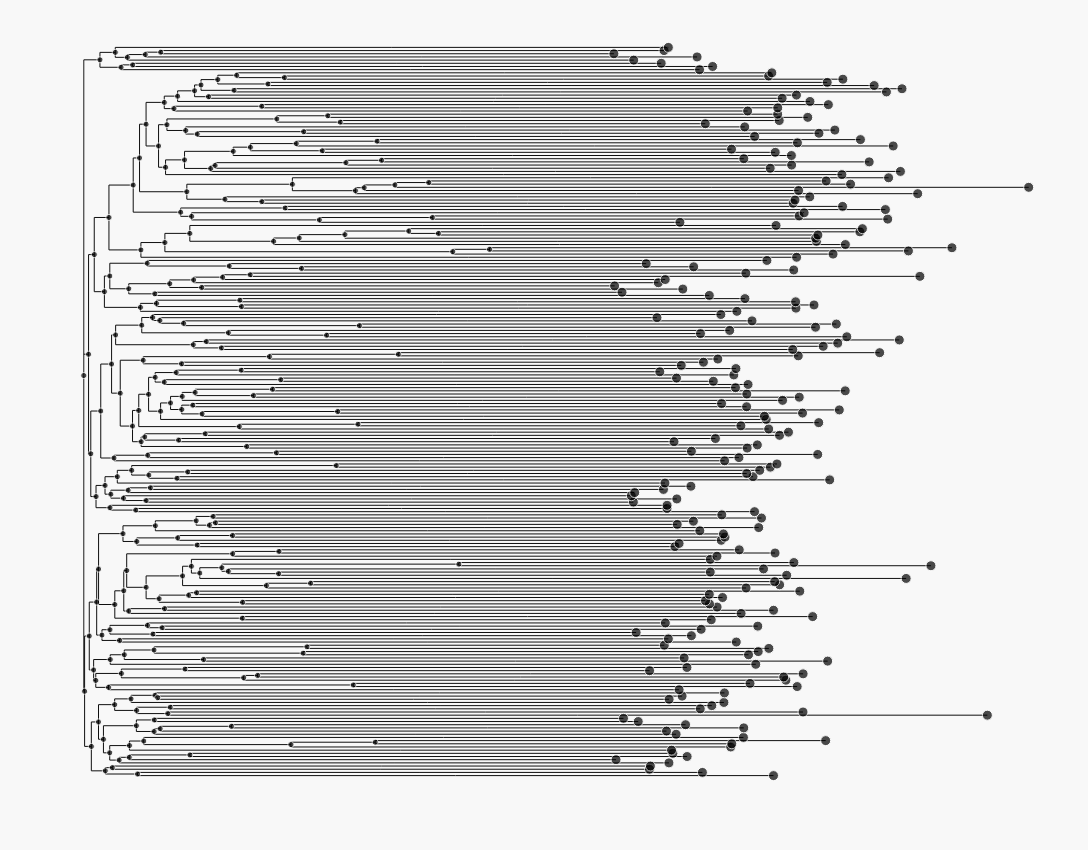

In [21]:
#node_color_dict = {acc:'red' for acc in outliers}
njTree_fig = jw_draw_tree.create_tree(njTree)#, node_color_dict=node_color_dict)
go.Figure(njTree_fig)